<a href="https://colab.research.google.com/github/jlgelpi/enzyme_kinetics/blob/main/enzyme_kinetics_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Main imports ##

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#

## Useful constants ##

In [ ]:
# Unhibition types
COMPETITIVE = 1
ACOMPETITIVE = 2
NONCOMPETITIVE = 3
MIXED = 4

## velocity functions and wrappers ##

In [45]:
def michaelis_menten_func(s, vm ,km):
  ''' return Vmax * s / (Km + s)'''
  return vm * s / (km + s)

def competitive_inh_func(si_pair, vm ,km, ki):
  ''' return  Competitive inh x pairs s,i '''
  s, i = si_pair
  i_factor = 1 + i/ki
  return vm * s / (km * ifactor + s)

def acompetitive_inh_func(si_pair, vm, km, ki):
  ''' return  ACompetitive inh  for x pairs s,i '''
  s, i = si_pair
  i_factor = 1 + i/ki
  return vm * s / (km + s * i_factor)

def non_competitive_inh_func(si_pair, vm ,km, ki):
  ''' return  non-competitive inh  for x pairs s,i '''
  s, i = si_pair
  i_factor = 1 + i/ki
  return vm * s / (km + s) / i_factor

def mixed_inh_func(si_pair, vm, km, kip, kii):
  ''' return  mixed inh  for x pairs s,i '''
  s, i = si_pair
  i_factor_p = 1 + i/kip
  i_factor_i = 1 + i/kii
  return vm * s / (km * i_factor_p + s * i_factor_i)

def lineweaver_burk_func(s, vm, km):
  ''' Return LW plot values '''
  return 1 / vm + km / vm / s

# Fitting wrappers based on non-linear regression
def fit_michaelis_menten(s, v):
  prm, cov = curve_fit(michaelis_menten_func, s, v)
  return {'vm': prm[0], 'vm_sd': np.sqrt(cov[0,0]), 'km': prm[1], 'km_sd': np.sqrt(cov[1,1])}

def fit_inh_func(inh_type, s, i, v):
  ''' Fit inhibition experiments n S values x n I values '''
  sdata = np.array([])
  idata = np.array([])
  for ival in i:
    for sval in s:
      sdata = np.append(sdata, sval)
      idata = np.append(idata, ival)
  vdata = v.reshape(-1)
  if inh_type == COMPETITIVE:
    func = competitive_inh_func
  elif inh_type == ACOMPETITIVE:
    func = acompetitive_inh_func
  elif inh_type == NONCOMPETITIVE:
    func = non_competitive_inh_func
  elif inh_type == MIXED:
    func = mixed_inh_func
  else:
    raise Exception(f"Unknown inhibition type {inh_type}")
  prm, cov = curve_fit(func, np.stack([sdata, idata]), vdata)
  if inh_type != MIXED:
    return {'vm': prm[0], 'vm_sd': np.sqrt(cov[0,0]), 'km': prm[1], 'km_sd': np.sqrt(cov[1,1]), 'ki': prm[2], 'ki_sd': np.sqrt(cov[2,2])}
  return  {'vm': prm[0], 'vm_sd': np.sqrt(cov[0,0]), 'km': prm[1], 'km_sd': np.sqrt(cov[1,1]), 'kip': prm[2], 'kip_sd': np.sqrt(cov[2,2]), 'kii': prm[2], 'kii_sd': np.sqrt(cov[2,2])}


## Examples ##

1. Three experiments: Non inhibition and two different inhibitors (A and B)

In [46]:
s = np.array([0.2, 0.4, 0.8, 1.6, 3.2])
vo = np.array([1.67, 2.86, 4.44, 6.15, 7.62])
via = np.array([0.625, 1.176, 2.110, 3.480, 5.16])
vib = np.array([0.83, 1.43, 2.22, 3.08, 3.81])

## Preliminar LW plots ##
A and B have different inhibition types

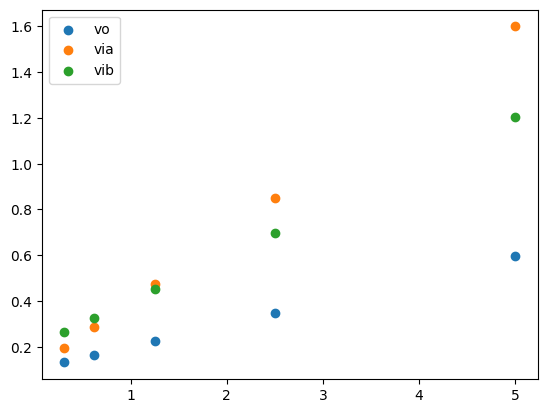

In [47]:
plt.scatter(1/s, 1/vo, label="vo")
plt.scatter(1/s, 1/via, label="via")
plt.scatter(1/s, 1/vib, label="vib")
plt.legend()
plt.show()

 Fitting three MM functions to data

In [56]:
no_inh = fit_michaelis_menten(s, vo)
a_inh = fit_michaelis_menten(s, via)
b_inh = fit_michaelis_menten(s, vib)


Note that A inhibitor shows same Km as reference (-> non-competitive) and B inhibitios shows same Vm as reference (-> competitive)

In [57]:
no_inh

{'vm': 9.24993629679294,
 'vm_sd': 0.2570936701513396,
 'km': 0.10522876359523083,
 'km_sd': 0.007956750674937967}

Plots with fitting results
Direct plots

In [58]:
a_inh

{'vm': 7.973987823161444,
 'vm_sd': 0.30805456139484344,
 'km': 0.2692462451376803,
 'km_sd': 0.021076208613808635}

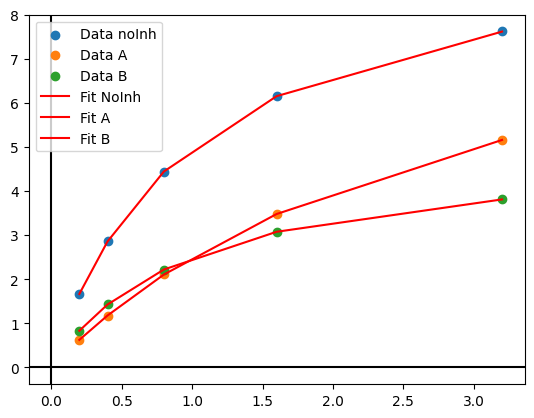

In [49]:
# Initial plot
plt.scatter(s, vo, label="Data noInh")
plt.scatter(s, via, label="Data A")
plt.scatter(s, vib, label="Data B")
# Draw axes for reference
plt.axvline(0., color="0")
plt.axhline(0., color="0")
# Fited plots
plt.plot(s, michaelis_menten_func(s, no_inh['vm'], no_inh['km']), "r-", label="Fit NoInh")
plt.plot(s, michaelis_menten_func(s, a_inh['vm'], a_inh['km']), "r-", label="Fit A")
plt.plot(s, michaelis_menten_func(s, b_inh['vm'], b_inh['km']), "r-", label="Fit B", )

plt.legend()
plt.show()

In [59]:
b_inh

{'vm': 4.629229425282674,
 'vm_sd': 0.12676878616105478,
 'km': 0.10540985635998427,
 'km_sd': 0.007848703888001055}

### LW plots ###
Note that A inhibition touches reference at X axis -> non-competitive and B inhibition touches at Y axis -> competitive

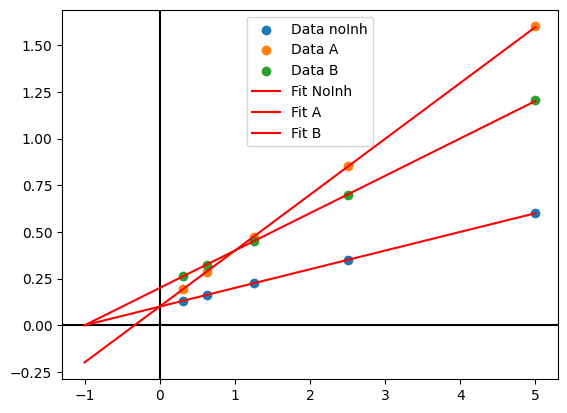

In [50]:
# Initial plot
plt.scatter(1/s, 1/vo, label="Data noInh")
plt.scatter(1/s, 1/via, label="Data A")
plt.scatter(1/s, 1/vib, label="Data B")
# Draw axes for reference
plt.axvline(0., color="0")
plt.axhline(0., color="0")
# Fited plots
s0 = np.append(s, -no_inh['km']) # added point to extend the plot to the left quadrant
plt.plot(1/s0, lineweaver_burk_func(s0, no_inh['vm'], no_inh['km']), "r-", label="Fit NoInh")
plt.plot(1/s0, lineweaver_burk_func(s0, a_inh['vm'], a_inh['km']), "r-", label="Fit A")
plt.plot(1/s0, lineweaver_burk_func(s0, b_inh['vm'], b_inh['km']), "r-", label="Fit B", )

plt.legend()
plt.show()

## 2. Complete inhibition experiment ##
All combinations of 5 S concetrations and 3  I concentrations (Note how v are introduced)

In [51]:
s = np.array([0.02, 0.05, 0.1, 0.2, 0.5])
i = np.array([0.,0.1, 1.])
v = np.array([
    [2.9, 5., 6.67, 8.13, 9.09],
    [2.52, 4.02, 5.02, 5.72, 6.25],
    [1.18, 1.43, 1.54, 1.6, 1.64]
])



Preliminar LW plots. Parallel lines indicate acompetitive inhibition

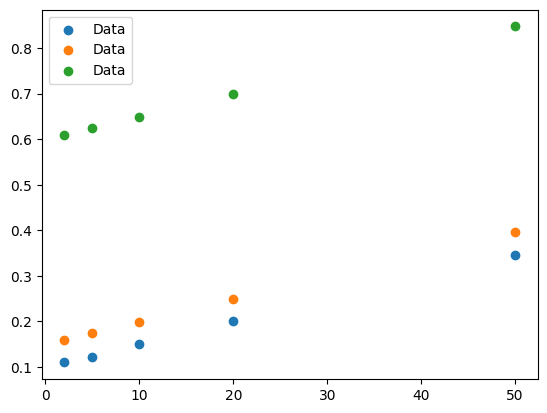

In [52]:
plt.scatter(1/s, 1/v[0], label="Data")
plt.scatter(1/s, 1/v[1], label="Data")
plt.scatter(1/s, 1/v[2], label="Data")
plt.legend()
plt.show()

Fitting to a acompetitive inhibition

In [54]:
acom_inh = fit_inh_func(ACOMPETITIVE, s, i, v)
acom_inh


{'vm': 10.036169266728145,
 'vm_sd': 0.035118720248020346,
 'km': 0.049690823527502245,
 'km_sd': 0.0005640365328688907,
 'ki': 0.19842779168406183,
 'ki_sd': 0.0020606668906524095}

Plots with fitted curves

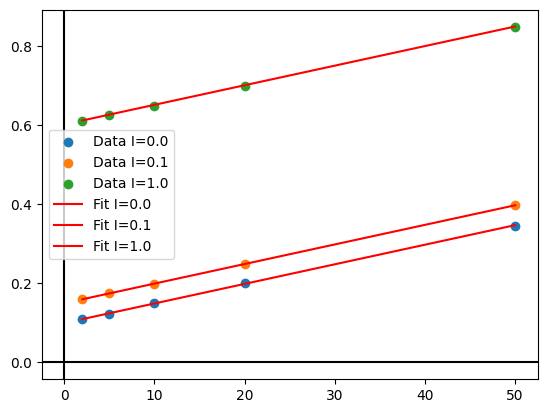

In [44]:
plt.scatter(1/s, 1/v[0], label=f"Data I=0.0")
plt.scatter(1/s, 1/v[1], label=f"Data I=0.1")
plt.scatter(1/s, 1/v[2], label=f"Data I=1.0")

plt.axvline(0., color="0")
plt.axhline(0., color="0")

for ival in i:
  vmap = acom_inh['vm'] / (1 + ival/acom_inh['ki'])
  kmap = acom_inh['km'] / (1 + ival/acom_inh['ki'])
  plt.plot(1/s, lineweaver_burk_func(s, vmap , kmap), "r-", label=f"Fit I={ival}")

plt.legend()
plt.show()